<img src="assets/dask_horizontal.svg"
     width="45%"
     alt="Dask logo\">
     
# Parallel Computing in Python with Dask

This notebook provides a high-level overview of Dask. We discuss why you might want to use Dask, the high-level and low-level APIs for generating computational graphs, and the schedulers which allow for the parallel execution of these graphs.

# Overview

### What is Dask?

- Dask is a flexible, open source library for parallel computing in Python

    - GitHub: [https://github.com/dask/dask](https://github.com/dask/dask)
    
    - Documentation: [https://docs.dask.org](https://docs.dask.org)

- Scales the existing Python ecosystem

### Why Dask?

- Enables parallel and larger-than-memory computations
- Uses familiar APIs you're used to from projects like NumPy, pandas, and scikit-learn
- Allows you to scale existing workflows with minimal code changes
- Dask works on your laptop, but also scales out to large clusters
- Offers great built-in diagnosic tools

### Dask vs. Spark

#### Reasons you might choose Spark

- You prefer Scala or the SQL language
- You have mostly JVM infrastructure and legacy systems
- You want an established and trusted solution for business
- You are mostly doing business analytics with some lightweight machine learning
- You want an all-in-one solution

#### Reasons you might choose Dask

- You prefer Python or native code, or have large legacy code bases that you do not want to entirely rewrite
- Your use case is complex or does not cleanly fit the Spark computing model
- You want a lighter-weight transition from local computing to cluster computing
- You want to interoperate with other technologies and don’t mind installing multiple packages

### Components of Dask

<img src="assets/dask-overview.png"
     width="85%"
     alt="Dask components\">
     

# Schedulers

High-level collections like Dask arrays and Dask DataFrames, as well as the low-level `dask.delayed` interface build up task graphs for a computation. After these graphs are generated, they need to be executed (potentially in parallel). This is the job of a task scheduler. Different task schedulers exist within Dask. Each will consume a task graph and compute the same result, but with different performance characteristics. 

![grid-search](assets/animation.gif "grid-search")

Dask has two different classes of schedulers: single-machine schedulers and a distributed scheduler.

### Single Machine Schedulers

Single machine schedulers provide basic features on a local process or thread pool and require no setup (only use the Python standard library). The different single machine schedulers Dask provides are:

- `'threads'`: The threaded scheduler executes computations with a local `concurrent.futures.ThreadPoolExecutor`. The threaded scheduler is the default choice for Dask arrays, Dask DataFrames, and Dask delayed. 

- `'processes'`: The multiprocessing scheduler executes computations with a local `concurrent.futures.ProcessPoolExecutor`.

- `'single-threaded'`: The single-threaded synchronous scheduler executes all computations in the local thread, with no parallelism at all. This is particularly valuable for debugging and profiling, which are more difficult when using threads or processes.

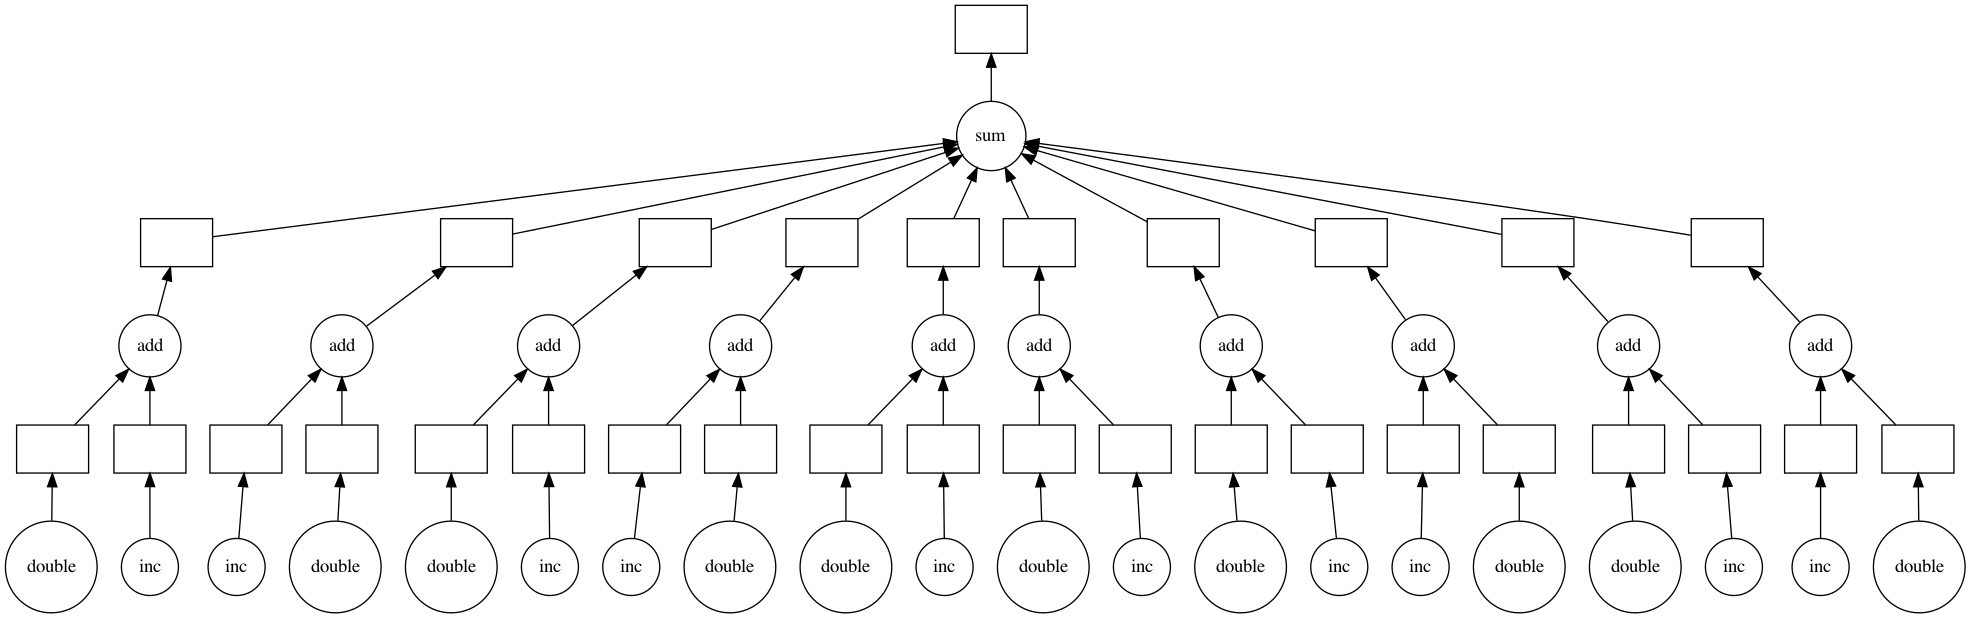

In [1]:
from dask import delayed
import time

@delayed
def inc(x):
    time.sleep(1)
    return x + 1

@delayed
def double(x):
    time.sleep(1)
    return 2 * x

@delayed
def add(x, y):
    time.sleep(1)
    return x + y

output = []
for x in range(10):
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

result = delayed(sum)(output)
result.visualize()

In [2]:
import dask
from datetime import datetime

"""
You can configure which scheduler is used in a few different ways. 
You can set the scheduler globally by using the 
`dask.config.set(scheduler=)` command
"""
tick = datetime.now()
dask.config.set(scheduler='single-threaded')
result.compute(); # Will use the single-threaded scheduler
tock = datetime.now()
print(f"Single-threaded scheduler: {tock - tick}")

"""
or use it as a context manager to set the scheduler for a block of code
"""
tick = datetime.now()
with dask.config.set(scheduler='processes'):
    result.compute()  # Will use the multi-processing scheduler
tock = datetime.now()
print(f"Multi-processing scheduler: {tock - tick}")

"""
or even within a single compute call
"""
tick = datetime.now()
result.compute(scheduler='threads');  # Will use the multi-threading scheduler
tock = datetime.now()
print(f"Multi-threading scheduler: {tock - tick}")

"""
The `num_workers` argument is used to specify the number of threads or processes to use
"""
tick = datetime.now()
result.compute(scheduler='threads', num_workers=4);
tock = datetime.now()
print(f"Multi-threading scheduler (with 4 workers): {tock - tick}")

Single-threaded scheduler: 0:00:30.076741
Multi-processing scheduler: 0:00:10.181815
Multi-threading scheduler: 0:00:03.016028
Multi-threading scheduler (with 4 workers): 0:00:08.017001


### Distributed Scheduler

Despite having "distributed" in it's name, the distributed scheduler works well on both single and multiple machines. Think of it as the "advanced scheduler".

A Dask distributed cluster is composed of a single centralized scheduler and one or more worker processes. A `Client` object is used as the user-facing entry point to interact with the cluster.

<img src="assets/dask-cluster.png"
     width="85%"
     alt="Dask components\">
     
You can manually create a cluster by setting up schedulers and workers using the `dask-scheduler` and `dask-worker` commands on the CLI.

```shell
$ dask-scheduler
distributed.scheduler - INFO - -----------------------------------------------
distributed.scheduler - INFO - -----------------------------------------------
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://192.168.62.218:8786
distributed.scheduler - INFO -   dashboard at:                     :8787
```

Then, you can launch a worker (or workers), providing the address of the `dask-scheduler` node.

```shell
$ dask-worker tcp://192.168.62.218:8786
distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.62.218:53109'
distributed.worker - INFO -       Start worker at: tcp://192.168.62.218:53110
distributed.worker - INFO -          Listening to: tcp://192.168.62.218:53110
distributed.worker - INFO -          dashboard at:       192.168.62.218:53111
distributed.worker - INFO - Waiting to connect to:  tcp://192.168.62.218:8786
distributed.worker - INFO - -------------------------------------------------
distributed.worker - INFO -               Threads:                         16
distributed.worker - INFO -                Memory:                  16.00 GiB
distributed.worker - INFO -       Local Directory: /Users/drewfustin/dask-worker-space/worker-3oc_5d0j
distributed.worker - INFO - -------------------------------------------------
distributed.worker - INFO -         Registered to:  tcp://192.168.62.218:8786
distributed.worker - INFO - -------------------------------------------------
distributed.core - INFO - Starting established connection
```

You can then create a `Client` object pointing to the scheduler.

In [1]:
from dask.distributed import Client

client = Client('tcp://192.168.62.218:8786')
client

Client Scheduler: tcp://192.168.62.218:8786 Dashboard: http://192.168.62.218:8787/status,Cluster Workers: 1 Cores: 16 Memory: 16.00 GiB


In [2]:
client.close()

There are, of course, helpers to handle this from python. 

You can either create a cluster object, which automatically provisions the scheduler and workers.

In [3]:
from dask.distributed import LocalCluster

# Launch a scheduler and 4 workers on my local machine
cluster = LocalCluster(n_workers=4, threads_per_worker=2)
cluster

In [4]:
# Scale up to 10 workers
cluster.scale(10)

In [5]:
# Scale down to 2 workers
cluster.scale(2)

In [6]:
# Retreieve cluster logs
cluster.get_logs()

{'Cluster': '',
 'Scheduler': "distributed.scheduler - INFO - Clear task state\ndistributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:60987\ndistributed.scheduler - INFO -   dashboard at:            127.0.0.1:8787\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:60993', name: 1, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:60993\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:60995', name: 2, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:60995\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:60994', name: 3, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:60994\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:60996', name: 0, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:60996\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:61016', name: 5, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:61016\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:61015', name: 4, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:61015\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:61017', name: 7, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:61017\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:61025', name: 8, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:61025\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:61024', name: 9, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:61024\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:61030', name: 6, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:61030\ndistributed.scheduler - INFO - Remove worker <Worker 'tcp://127.0.0.1:60995', name: 2, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Remove worker <Worker 'tcp://127.0.0.1:60994', name: 3, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Remove worker <Worker 'tcp://127.0.0.1:61015', name: 4, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Remove worker <Worker 'tcp://127.0.0.1:61016', name: 5, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Remove worker <Worker 'tcp://127.0.0.1:61030', name: 6, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Remove worker <Worker 'tcp://127.0.0.1:61017', name: 7, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Remove worker <Worker 'tcp://127.0.0.1:61025', name: 8, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Remove worker <Worker 'tcp://127.0.0.1:61024', name: 9, memory: 0, processing: 0>",
 'tcp://127.0.0.1:60993': 'distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:60993\ndistributed.worker - INFO -          Listening to:      tcp://127.0.0.1:60993\ndistributed.worker - INFO -          dashboard at:            127.0.0.1:61002\ndistributed.worker - INFO - Waiting to connect to:      tcp://127.0.0.1:60987\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -               Threads:                          2\ndistributed.worker - INFO -                Memory:                   4.00 GiB\ndistributed.worker - INFO -       Local Directory: /Users/drewfustin/code/kar-roundtable-dask/dask-worker-space/worker-9acsoev_\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -         Registered to: 

In [7]:
# Shut down cluster
cluster.close()

There are several projects in the Dask ecosystem for easily deploying clusters on commonly used computing resources:

- [Dask-Kubernetes](https://kubernetes.dask.org/en/latest/) for deploying Dask using native Kubernetes APIs
- [Dask-Cloudprovider](https://cloudprovider.dask.org/en/latest/) for deploying Dask clusters on various cloud platforms (e.g. AWS, GCP, Azure, etc.)
- [Dask-Yarn](https://yarn.dask.org/en/latest/) for deploying Dask on YARN clusters
- [Dask-MPI](http://mpi.dask.org/en/latest/) for deploying Dask on existing MPI environments
- [Dask-Jobqueue](https://jobqueue.dask.org/en/latest/) for deploying Dask on job queuing systems (e.g. PBS, Slurm, etc.)

Launching clusters with any of these projects follows a similar pattern as using Dask's built-in `LocalCluster`:

```python
# Launch a Dask cluster on a Kubernetes cluster
from dask_kubernetes import KubeCluster
cluster = KubeCluster(...)

# Launch a Dask cluster on AWS Fargate
from dask_cloudprovider.aws import FargateCluster
cluster = FargateCluster(...)

# Launch a Dask cluster on a PBS job queueing system
from dask_jobqueue import PBSCluster
cluster = PBSCluster(...)
```

Additionally, there are compaines like [Coiled](https://coiled.io) and [Saturn Cloud](https://www.saturncloud.io) which have Dask deployment-as-a-service offerings.

#### Related Documentation

- [Cluster setup](https://docs.dask.org/en/latest/setup.html)

You can also create the distributed scheduler locally by creating a `Client` object, which lets you interact with the "cluster" (local threads or processes on your machine), which is automatically set up. 

In [8]:
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:61047 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.00 GiB


Notice the dashboard link. You can go there, or could make use of the `dask-labextension` package to view several plots within your Jupyter Lab. 

Let's open the Task Stream, Graph, Progress, and Scheduler System.

In [9]:
result.compute()

145

In [10]:
client.shutdown()